# L8c: Introduction to Q-Learning
In this lecture, we'll continue our discussion of reinforcement learning concepts and explore model-free off-policy Q-learning. We'll start by examining the Q-learning algorithm. Additionally, we'll cover the convergence of Q-learning. Finally, we'll discuss the limitations of Q-learning and explore how to overcome these limitations using [deep Q-learning (an advanced topic)](https://arxiv.org/abs/1810.06339). 

The key ideas of this lecture are:
* Q-learning is a model-free off-policy algorithm that learns the optimal state-action-value function $Q(s, a)$ by experimenting with the environment. This is done by updating the Q-values using the Bellman equation. The optimal policy is then derived from the optimal Q-values: $\pi^*(s) = \arg\max_a Q^*(s, a)$.
* Convergence to the optimal Q-values requires a decay in the learning rate and (potentially) infinite exploration, with the discount factor $0<\gamma<1$ for infinite-horizon problems, and the environment must adhere to the Markov property.
* The $\epsilon$-greedy algorithm balances exploration and exploitation in Q-learning. The agent chooses the action with the highest Q-value with probability $1-\epsilon$ and a random action with probability $\epsilon$. The threshold $\epsilon$ decays over time to promote initial exploration and later exploitation.

The notes for today were inspired by the [Reinforcement Learning (RL) course ](https://gibberblot.github.io/rl-notes/) prepared by [Prof. Tim Miller from The University of Queensland](https://uqtmiller.github.io).

## Q-Learning Theory
Q-learning estimates the action-value function $Q(s, a)$ by conducting repeated experiments $t=1,2,\ldots$ in the world $\mathcal{W}$. 
In each experiment, an agent in state $s\in\mathcal{S}$ takes action $a\in\mathcal{A}$, receives a reward $r$, and (potentially) transitions to a new state $s^{\prime}$. After each experiment $t$, the agent updates its estimate of $Q(s, a)$ using the update rule:
$$
\begin{equation*}
Q_{t+1}(s,a)\leftarrow{Q_{t}(s,a)}+\alpha_{t}\cdot\underbrace{\left(r+\gamma\cdot\max_{a^{\prime}\in\mathcal{A}}Q_{t}(s^{\prime},a^{\prime}) - Q_{t}(s,a)\right)}_{\text{new information}}\quad{t = 1,2,3,\ldots}
\end{equation*}
$$
where $0<\alpha_{t} <{1}$ is the learning rate parameter at time $t$, and $0<\gamma<{1}$ is the discount factor. 
We estimate the policy function $\pi:\mathcal{S}\rightarrow\mathcal{A}$ by selecting the action $a$ that maximizes $Q(s,a)$ at each state $s$:
$$
\begin{equation*}
\pi(s) = \arg\max_{a\in\mathcal{A}}Q(s,a)
\end{equation*}
$$

### Algorithm
Initialize $Q(s,a)$ arbitrarily for all $s\in\mathcal{S}$, and $a\in\mathcal{A}$.
Set the hyperparameters: learning rate $\alpha_{t}$, the discount factor $\gamma$, the exploration rate $\epsilon_{t}$, and the convergence tolerance $\delta$.

For $s\in\mathcal{S}$
1. Initialize the time $t\gets{1}$
2. While not converged:
    1. Role a random number $p\in[0,1]$.
    2. If $p\leq\epsilon_{t}$, choose a random (uniform) action $a_{t}\in\mathcal{A}$. Otherwise, choose a greedy action $a_{t} = \text{arg}\max_{a\in\mathcal{A}}{Q_{t}(s,a)}$.
    3. Take action $a_{t}$, observe the reward $r$ from the _world_ and transition to the next state $s^{\prime}$.
    4. Update the state-action-value function: $Q_{t+1}(s,a)\leftarrow{Q_{t}(s,a)}+\alpha_{t}\cdot\underbrace{\left(r+\gamma\cdot\overbrace{\max_{a^{\prime}\in\mathcal{A}}Q_{t}(s^{\prime},a^{\prime})}^{\text{one-step lookahead}} - Q_{t}(s,a)\right)}_{\text{new information}}$.
    5. Update the state $s\leftarrow{s^{\prime}}$, the time $t\leftarrow{t+1}$, the exploration rate $\epsilon_{t+1}\leftarrow\epsilon_{t}$ and the learning rate $\alpha_{t+1}\leftarrow\alpha_{t}$.
    6. Check for convergence. if the $Q(s,a)$ has bounded change $\lVert{Q_{t+1}(s,a) - Q_{t}(s,a)}\rVert\leq\delta$, then the algorithm has _converged_. Otherwise, continue.
3. End While
4. End For

### Convergence
Q-learning converges to the optimal policy under two key theoretical conditions (assuming the Markov property holds for the world):
* __Learning rate decay__: The learning rate $\alpha_{t}$ must satisfy $\sum_{t=0}^\infty \alpha_t(s, a) = \infty$ and $\sum_{t=0}^\infty \alpha_t^2(s, a) < \infty$ for all state-action pairs, ensuring sufficient initial updates while stabilizing over time. Thus, $\alpha_t \sim 1/t$ or, alternatively, $\alpha_t \gets \beta\alpha_{t}$ where $\beta<1$ are common choices.
* __Infinite exploration__: All state-action pairs _can_ be visited infinitely often. This condition is true for $\epsilon$-greedy policies with persistent exploration, i.e., $\epsilon_{t} > 0\,\,\forall{t}$.

## Example: Q-Learning in a Grid World
Yesterday in the lab, we discussed solving the [roomba](https://www.irobot.com) navigation problem using [Value iteration](https://gibberblot.github.io/rl-notes/single-agent/Value-Iteration.html). Let's solve the same problem using [the temporal learning Q-learning algorithm](https://gibberblot.github.io/rl-notes/single-agent/temporal-difference-learning.html#temporal-difference-td-reinforcement-learning). First, let's set up the computational environment by importing the necessary libraries (and codes) by including the `Include.jl` file.

In [4]:
include("Include.jl");

In [5]:
function rbf(x::Tuple{Int,Int},y::Tuple{Int,Int}; σ = 1.0)::Float64
    d = sqrt((x[1] - y[1])^2 + (x[2] - y[2])^2);
    return exp(-d/(2*σ^2))
end;

### Build the world model
Next, we set parameters associated with the world. We encoded the `rectangular grid world` using the `MyRectangularGridWorldModel` model, which we constructed using a `build(...)` method. Let's set up the data for the world, set up the states, actions, and rewards, and then construct the world model. 
* First, set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` available to the agent, and the `discount factor` $\gamma$. Then, we'll compute the number of states and set the state set $\mathcal{S}$ and the action set $\mathcal{A}$

In [7]:
number_of_rows = 30; # number of rows in the grid world
number_of_cols = 30; # number of cols in the grid world
nactions = 4; # number of actions (LRUD)
γ = 0.95; # discount factor
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;

Now, let's set up a description of the rewards, the `rewards::Dict{Tuple{Int, Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. In an `MDP,` this will be visible to the agent; however, in `Q-learning,` the rewards (and physics) are features of the world model and are unknown to the agent.
  * Formulate the `terminal states`, e.g., the `charging station` location, the `lava pits` and other constraints such as `softwalls` (not terminal, states but locations to avoid). Set the reward for these states according to their identity. Don't forget to add the `terminal states` to the `absorbing_state_set.`

In [9]:
# setup rewards -
lava_reward = -1000.0;
charging_reward = 100.0;
softwall_reward = -2000.0;
σ = 1.0;
default_reward = -1.0;
charging_location = (5,6)

# setup rewards -
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(5,5)] =  lava_reward # lava in the (5,5) square 
rewards[(6,5)] = lava_reward # lava in the (6,5) square
rewards[(6,6)] = lava_reward # lava in the (6,6) square
rewards[charging_location] = charging_reward    # charging station square

# walls?
soft_wall_set = Set{Tuple{Int,Int}}();
push!(soft_wall_set, (2,1));
push!(soft_wall_set, (2,2));
push!(soft_wall_set, (2,3));
push!(soft_wall_set, (7,4));
push!(soft_wall_set, (4,6));

# chair or shoe?
# push!(soft_wall_set, (20,16));
# push!(soft_wall_set, (20,17));
# push!(soft_wall_set, (20,18));
# push!(soft_wall_set, (20,19));
# push!(soft_wall_set, (20,20));
# push!(soft_wall_set, (20,21));
# push!(soft_wall_set, (20,22));
# push!(soft_wall_set, (20,23));
# push!(soft_wall_set, (20,24));
# push!(soft_wall_set, (20,25));
# push!(soft_wall_set, (20,26));
# push!(soft_wall_set, (20,27));
# push!(soft_wall_set, (20,28));
# push!(soft_wall_set, (20,29));
# push!(soft_wall_set, (20,30));
# push!(soft_wall_set, (19,16));
# push!(soft_wall_set, (19,17));
# push!(soft_wall_set, (19,18));
# push!(soft_wall_set, (19,19));
# push!(soft_wall_set, (19,20));
# push!(soft_wall_set, (19,21));
# push!(soft_wall_set, (18,16));
# push!(soft_wall_set, (18,17));
# push!(soft_wall_set, (18,18));
# push!(soft_wall_set, (18,19));
# push!(soft_wall_set, (18,20));
# push!(soft_wall_set, (18,21));

for s in soft_wall_set
    rewards[s] = softwall_reward;
end

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
for (k,v) ∈ rewards
    push!(absorbing_state_set, k); 
end 

### Reward shaping
In cases where rewards are sparse, there are few $(s, a)$ pairs that lead to non-zero rewards. This is an issue because reinforcement learning algorithms, e.g., `Q-learning,` behave randomly initially when the state-action-value function $Q(s, a)$ is unknown. 
* [Reward shaping](https://gibberblot.github.io/rl-notes/single-agent/reward-shaping.htmlhttps://gibberblot.github.io/rl-notes/single-agent/reward-shaping.html) is an approach to address this issue, by modifying the reward function to promote behavior that we think will move us closer to the goal state, e.g., the `charging_station`. There are different approaches to this. We'll use a [radial basis kernel function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) to distribute charging station rewards radially from the goal state.

In [11]:
rewards, is_reward_shaping_on = let
    
    # do some shaping?
    is_reward_shaping_on = true;
    if (is_reward_shaping_on == true)
        for s in 𝒮
            for s′ in 𝒮
                coordinate = (s,s′);
                if (haskey(rewards, coordinate) == false && in(coordinate,soft_wall_set) == false && 
                        in(coordinate,absorbing_state_set) == false)
                    rewards[coordinate] = default_reward + charging_reward*rbf(coordinate, charging_location, σ = σ);
                end
            end
        end
    end
    rewards, is_reward_shaping_on
end;

Finally, build an instance of the `MyRectangularGridWorldModel` type, which models the grid world. We save this instance in the `world_model` variable. Pass in the number of rows `nrows`, number of cols `ncols`, and our initial reward description in the `rewards` field into the `build(...)` method

In [13]:
world_model = build(MyRectangularGridWorldModel, (
            nrows=number_of_rows, ncols=number_of_cols, rewards = rewards, defaultreward = default_reward));

### Build the Q-learning agent
Next, we build a Q-learning agent model, i.e., the code representation of the [roomba](https://www.irobot.com) using [the `MyQLearningAgentModel` type](src/Types.jl) and an associated [`build(...)` function](src/Factory.jl). The learning rate parameter `α` describes the weight of the update step (how we incorporate new information), while the discount rate `γ` is the weight of future steps. In this example, we initialize `Q` to a matrix of zeros.

In [15]:
agent_model = let
   
    α = 0.90;  # learning rate
    nstates = (number_of_rows*number_of_cols);
    agent_model = build(MyQLearningAgentModel, (
        states = 𝒮,
        actions = 𝒜,
        α = α,
        γ = γ,
        Q = zeros(nstates,nactions) # Hmmm. Could we do something better than this?
    ));

    agent_model;
end;

### Solve and visualize
To solve the model, we pass the `agent` and `world` models to [the `solve(...)` function](src/Factory.jl). The [`solve(...)` method](src/Compute.jl) returns back an updated agent model with an updated `Q::Array{Float64,2}` field. 
* __Notice__ that we don't always get the same answer if we run this multiple times. We might consider the idea of `episodes,` a complete sequence of interactions between an agent and its environment, starting from an initial state and ending at a terminal state. We could then report the collection of possible policies or a consensus policy based on the average state-action-value table. Let's noodle on that and explore that idea tomorrow in the lab.

In [17]:
Q, my_π = let
    
    # run an episode, and grab the Q
    result = solve(agent_model, world_model, maxsteps = 10000, δ = 0.0000001);

    # get Q -
    Q = result.Q;
    my_π = policy(Q);

    Q,my_π
end;

`Unhide` the code block below to see how we plot the path through our grid world that [roomba](https://www.irobot.com/en_US/roomba.html?source=google_paid&medium=cpc&ds_campaign=US+-+Conversion+-+Brand+-+SEM+-+Roomba+-+Core+-+Exact&ds_content=Core+-+Roomba+-+Exact&ds_keyword=roomba&gad_source=1&gclid=EAIaIQobChMIu_65qsfYhQMVImJHAR3i1wTGEAAYASAAEgKwgfD_BwE&gclsrc=aw.ds) uses to get back to the charging station (shown as the green circle) while navigating around the lava pits (should as red circles).  To start the visualization, specify the `startstate` tuple:

In [19]:
startstate = (30,30); # start position (row, col) where lower left is (1,1)

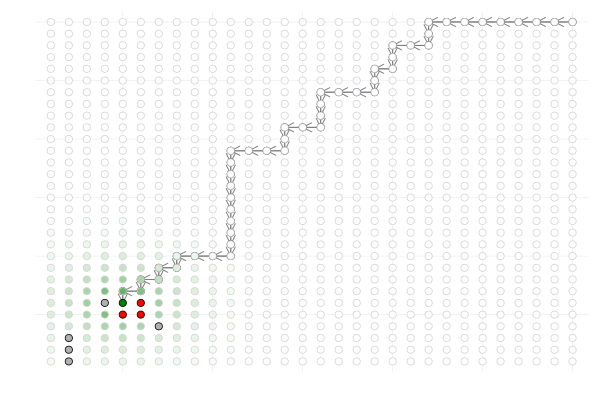

In [20]:
let
    # draw the path -
    p = plot();
    initial_site = startstate
    hit_absorbing_state = false
    s = world_model.states[initial_site];
    visited_sites = Set{Tuple{Int,Int}}();
    push!(visited_sites, initial_site);
    
    while (hit_absorbing_state == false)
        current_position = world_model.coordinates[s]
        a = my_π[s];
        Δ = world_model.moves[a];
        new_position =  current_position .+ Δ
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
        plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=1, c=:gray)
        
        if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
            hit_absorbing_state = true;
        elseif (haskey(world_model.states, new_position) == true)
            s = world_model.states[new_position];
            push!(visited_sites, new_position);
        else
            hit_absorbing_state = true; # we drove off the map
        end
    end
    
    # draw the grid -
    for s ∈ 𝒮
        current_position = world_model.coordinates[s]
        a = my_π[s];
        Δ = world_model.moves[a];
        new_position =  current_position .+ Δ
        
        if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=4)
        elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=4)
        elseif (in(current_position, soft_wall_set) == true)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
        else
            if (is_reward_shaping_on == true)
                new_color = weighted_color_mean(rbf(current_position, (5,6), σ = σ), colorant"green", colorant"white")
                scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:lightgray, c=new_color)
            else
                scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
            end
        end
    end
    current()
end

## Limitations of Q-learning
Tabular Q-learning has several key limitations:  
* __Scalability of tabular methods__: The reliance on a Q-table becomes impractical in large or continuous state-action spaces due to exponential memory growth (e.g., millions of state entries), leading to slow convergence and inefficient learning.
* __Discrete state-action requirement__: The tabular Q-learning algorithm inherently struggles with continuous state spaces, requiring discretization techniques that trade precision for computational feasibility.
* __Overestimation bias__: Noisy environments can cause Q-learning to overestimate action values, resulting in suboptimal policies. [Double Q-learning](https://papers.nips.cc/paper_files/paper/2010/hash/091d584fced301b442654dd8c23b3fc9-Abstract.html) can be used to address this issue.  
* __Delayed rewards__: Q-learning struggles with delayed rewards. It may not learn the optimal policy due to the temporal difference (TD) reliance on immediate rewards. We have to make decisions before we know the outcome of previous decisions. In the advanced topic section, we'll consider [this study that explores the delayed rewards problem](https://arxiv.org/abs/2106.11854).

## Lab
In `L8d`, we will implement the $\epsilon$-Greedy algorithm to solve a Q-learning problem in a $n$-product consumer choice problem.

# Today?
That's a wrap! What are some of the interesting things we discussed today?